In [ ]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [1]:

import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Dropout, Conv1D, MaxPool1D, Flatten, concatenate, Dense, \
    LSTM, Bidirectional, Activation, MaxPooling1D, Add, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, \
    TimeDistributed, Permute, multiply, Lambda, add, Masking, BatchNormalization, Softmax, Reshape, ReLU, \
    ZeroPadding1D, subtract
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import backend as K, initializers, regularizers, constraints


# Import our dependencies
import tensorflow as tf
import pandas as pd
# import tensorflow_hub as hub
import os
import re
from tensorflow.keras import backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, InputSpec
import numpy as np

from statistics import mode

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import nltk 
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
%matplotlib inline
import tensorflow as tf

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, TFAutoModel

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.metrics import Metric
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list
# import tensorflow_hub as hub



import re
import nltk
from nltk.corpus import stopwords

# neural
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

#Metrics 
from sklearn.metrics import balanced_accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
# from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier


2023-05-16 10:02:25.470112: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
df = pd.read_csv("Laptop_Train_v2.csv", encoding='utf8').dropna()
df.columns = ['id', "Sentence", "Aspect Term", 'polarity', 'from', 'to']
df = df[[ "Sentence", "Aspect Term", 'polarity']]

In [3]:
df.head()

,Sentence,Aspect Term,polarity
0,I charge it at night and skip taking the cord ...,cord,neutral
1,I charge it at night and skip taking the cord ...,battery life,positive
3,The tech guy then said the service center does...,service center,negative
4,The tech guy then said the service center does...,"""sales"" team",negative
5,The tech guy then said the service center does...,tech guy,neutral


In [4]:
df['polarity'].replace("positive", 2, inplace=True)
df['polarity'].replace("neutral", 1, inplace=True)
df['polarity'].replace("negative", 0, inplace=True)

In [5]:
df.head()

,Sentence,Aspect Term,polarity
0,I charge it at night and skip taking the cord ...,cord,1
1,I charge it at night and skip taking the cord ...,battery life,2
3,The tech guy then said the service center does...,service center,0
4,The tech guy then said the service center does...,"""sales"" team",0
5,The tech guy then said the service center does...,tech guy,1


In [6]:
df.drop(df[df.polarity == 'conflict'].index, inplace = True)

In [7]:
df.head()

,Sentence,Aspect Term,polarity
0,I charge it at night and skip taking the cord ...,cord,1
1,I charge it at night and skip taking the cord ...,battery life,2
3,The tech guy then said the service center does...,service center,0
4,The tech guy then said the service center does...,"""sales"" team",0
5,The tech guy then said the service center does...,tech guy,1


In [8]:
## Training data shape 
df.shape

(2313, 3)

<AxesSubplot: >

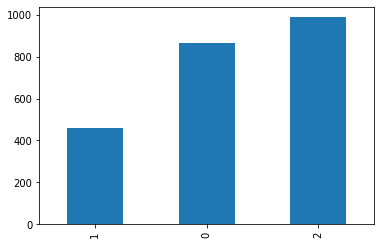

In [10]:
# Polarities distribution in our dataset
df.polarity.value_counts().sort_values().plot(kind = 'bar')


In [12]:
## Convert polarity Values to Integers 
df["polarity"] = pd.to_numeric(df["polarity"],errors='coerce')


In [13]:
## Display our training Dataframe 
df.head()

,Sentence,Aspect Term,polarity
0,I charge it at night and skip taking the cord ...,cord,1
1,I charge it at night and skip taking the cord ...,battery life,2
3,The tech guy then said the service center does...,service center,0
4,The tech guy then said the service center does...,"""sales"" team",0
5,The tech guy then said the service center does...,tech guy,1


In [14]:
## Split the Dataset into Training and Testing Datasets
train_df = df
X_train, X_test, y_train, y_test = train_test_split(train_df,train_df['polarity'],stratify=train_df['polarity'], test_size=0.2, random_state=1)

In [17]:
# the size of the training dataset
# Display the shape of the target values!

X_train.Sentence.size, y_train.shape


(1850, (1850,))

In [18]:
NUM_WORDS = 100000 ## MAx of words to keep, based on word frequency.
EMBEDDING_SIZE = 128 ## the length of the Vector the will 

In [19]:
tokenizer = Tokenizer(num_words=NUM_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True, )
## Fit_on_texts : Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(list(X_train.Sentence))
text_X_train_tokenized = tokenizer.texts_to_sequences(X_train.Sentence) # list of tokenized sentences
Aspect_X_train_tokenized = tokenizer.texts_to_sequences(X_train['Aspect Term']) # list of tokenized sentences
text_X_test_tokenized = tokenizer.texts_to_sequences(X_test.Sentence) # list of tokenized sentences
Aspect_X_test_tokenized = tokenizer.texts_to_sequences(X_test['Aspect Term']) # list of tokenized sentences

In [20]:
##Maximum length of sentences
Max_Len =  max([len(one_title) for one_title in text_X_train_tokenized])
Max_Len

77

In [21]:
## Pads sequences(or sentences) to the same length.


text_X_train_padded = pad_sequences(text_X_train_tokenized, maxlen=Max_Len)
aspect_X_train_padded = pad_sequences(Aspect_X_train_tokenized, maxlen=1)

text_X_test_padded = pad_sequences(text_X_test_tokenized, maxlen=Max_Len)
aspect_X_test_padded = pad_sequences(Aspect_X_test_tokenized, maxlen=1)


In [23]:
## Concatenate the Embedding presentation of the sentences and aspects to Create training and testing dataset 
train_data =  [text_X_train_padded,aspect_X_train_padded]
test_data =   [text_X_test_padded,aspect_X_test_padded]

## Attention Mechanism 

In [25]:

# modified based on `https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2`
class Attention(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
 e: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self, W_regularizer=None, u_regularizer=None, b_regularizer=None, W_constraint=None,
                 u_constraint=None, b_constraint=None, use_W=True, use_bias=False, return_self_attend=False,
                 return_attend_weight=True, **kwargs):
        self.supports_masking = True

        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.use_W = use_W
        self.use_bias = use_bias
        self.return_self_attend = return_self_attend    # whether perform self attention and return it
        self.return_attend_weight = return_attend_weight    # whether return attention weight
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        if self.use_W:
            self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),  initializer=self.init,
                                     name='{}_W'.format(self.name), regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)
        if self.use_bias:
            self.b = self.add_weight(shape=(input_shape[1],), initializer='zero', name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer, constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],), initializer=self.init, name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer, constraint=self.u_constraint)
        
        super(Attention, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        if self.use_W:
            x = K.tanh(K.dot(x, self.W))

        ait = Attention.dot_product(x, self.u)
        if self.use_bias:
            ait += self.b

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        if self.return_self_attend:
            attend_output = K.sum(x * K.expand_dims(a), axis=1)
            if self.return_attend_weight:
                return [attend_output, a]
            else:
                return attend_output
        else:
            return a

    def compute_output_shape(self, input_shape):
        if self.return_self_attend:
            if self.return_attend_weight:
                return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[1])]
            else:
                return input_shape[0], input_shape[-1]
        else:
            return input_shape[0], input_shape[1]

    @staticmethod
    def dot_product(x, kernel):
        """
        Wrapper for dot product operation, in order to be compatible with both
        Theano and Tensorflow
        Args:
            x (): input
            kernel (): weights
        Returns:
        """
        if K.backend() == 'tensorflow':
            return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
        else:
            return K.dot(x, kernel)

## LSTM with Aspect Embedding

In [26]:
def ae_lstm(lstm_units = 512):
    input_text = Input(shape=(Max_Len,))
    input_aspect = Input(shape=(1,),)
    
    word_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    text_embed = SpatialDropout1D(0.2)(word_embedding(input_text))
    
    asp_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    aspect_embed = asp_embedding(input_aspect)
    input_shape = aspect_embed.shape.as_list()

# Reshape the tensor to have a known batch size
    aspect_embed = tf.reshape(aspect_embed, shape=(-1, input_shape[1], input_shape[2]))
    
    
    aspect_embed = Flatten()(aspect_embed)  # reshape to 2d
    repeat_aspect = RepeatVector(Max_Len)(aspect_embed)  # repeat aspect for every word in sequence

    input_concat = concatenate([text_embed, repeat_aspect], axis=-1)
    hidden = LSTM(lstm_units)(input_concat)
    Dense_layer  = Dense(128, activation='relu')(hidden)
    output_layer = Dense(3, activation='softmax')(Dense_layer)
    return Model([input_text, input_aspect], output_layer)

In [27]:
ae_lstm_model = ae_lstm()
ae_lstm_model.summary()

2023-05-16 10:04:07.425080: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-05-16 10:04:07.462085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2023-05-16 10:04:07.462782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 1 with properties: 
pciBusID: 0000:81:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2023-05-16 10:04:07.462825: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-16 10:04:07.470214: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       12800000    input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 77)]         0                                            
__________________________________________________________________________________________________
tf.reshape (TFOpLambda)         (None, 1, 128)       0           embedding_1[0][0]                
______________________________________________________________________________________________

In [28]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(ae_lstm_model, to_file=dot_img_file, show_shapes=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [29]:
y_train.size

1850

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience = 1,
                                                    verbose=1,
                                                    factor=0.1,
                                                    min_lr=0.000001)
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.01)

ae_lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
history =  ae_lstm_model.fit(x = train_data, y = y_train,validation_data = (test_data, y_test), batch_size=16, epochs=20, callbacks = [learning_rate_reduction])

2023-05-16 10:04:22.864591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-05-16 10:04:22.885354: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1699915000 Hz


Epoch 1/20


2023-05-16 10:04:25.411469: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-05-16 10:04:25.950503: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8201
2023-05-16 10:04:26.081527: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-05-16 10:04:26.639547: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


116/116 [==============================] - 28s 208ms/step - loss: 1.2268 - accuracy: 0.4070 - val_loss: 1.0365 - val_accuracy: 0.5659
Epoch 2/20
116/116 [==============================] - 23s 197ms/step - loss: 0.9135 - accuracy: 0.6168 - val_loss: 0.9845 - val_accuracy: 0.5594

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 3/20
116/116 [==============================] - 23s 199ms/step - loss: 0.8078 - accuracy: 0.7054 - val_loss: 0.9733 - val_accuracy: 0.5659

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 4/20
116/116 [==============================] - 23s 197ms/step - loss: 0.7727 - accuracy: 0.7189 - val_loss: 0.9811 - val_accuracy: 0.5594

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 5/20
116/116 [==============================] - 23s 199ms/step - loss: 0.7683 - accuracy: 0.7216 - val_loss: 0.9811 - val_accuracy: 0.5594

Epoch 00005: ReduceLROnPlateau reducing le

In [31]:
val_data =   [text_X_test_padded[6].reshape(1,Max_Len),aspect_X_test_padded[6]]
print(val_data[0].shape)
ae_lstm_model.predict(val_data)

(1, 77)


array([[0.3950421 , 0.30223602, 0.30272183]], dtype=float32)

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [32]:
print("Evaluate on test data")
results = ae_lstm_model.evaluate(x = test_data , y = y_test )
print("test loss, test acc:", results)
print("Accuracy of the model is - " , results[1]*100 , "%")

Evaluate on test data
15/15 [==============================] - 0s 8ms/step - loss: 0.9819 - accuracy: 0.5594
test loss, test acc: [0.9818634390830994, 0.5593952536582947]
Accuracy of the model is -  55.93952536582947 %


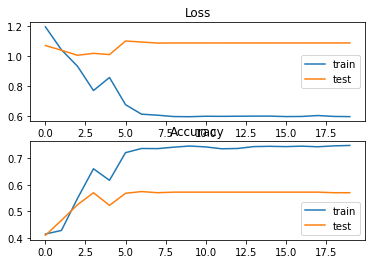

In [49]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

##  Attention-based LSTM (AT-LSTM)

In [53]:
def at_lstm(lstm_units = 512):
        input_text = Input(shape=(Max_Len,))
        input_aspect = Input(shape=(1,),)
        
        word_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
        text_embed = SpatialDropout1D(0.2)(word_embedding(input_text))
    
        asp_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
        aspect_embed = asp_embedding(input_aspect)
        aspect_embed = Flatten()(aspect_embed)  # reshape to 2d
        repeat_aspect = RepeatVector(Max_Len)(aspect_embed)  # repeat aspect for every word in sequence
        hidden_vecs = LSTM(lstm_units, return_sequences=True)(text_embed)  # hidden vectors output by lstm
        concat = concatenate([hidden_vecs, repeat_aspect], axis=-1)  # mask after concatenate will be same as hidden_out's mask
        print(concat.shape)
         # apply attention mechanism
        attend_weight = Attention()(concat)
        attend_weight_expand = Lambda(lambda x: K.expand_dims(x))(attend_weight)
        attend_hidden = multiply([hidden_vecs, attend_weight_expand])
        attend_hidden = Lambda(lambda x: K.sum(x, axis=1))(attend_hidden)
        Dense_layer  = Dense(128, activation='relu')(attend_hidden)
        output_layer = Dense(3, activation='softmax')(Dense_layer)
        return Model([input_text, input_aspect], output_layer)

In [54]:
at_lstm_model =  at_lstm()
at_lstm_model.summary()

(None, 69, 640)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 69)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 69, 128)      12800000    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 128)       12800000    input_4[0][0]                    
____________________________________________________________________________

## model training


In [55]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience = 1,
                                                    verbose=1,
                                                    factor=0.1,
                                                    min_lr=0.000001)
opt = keras.optimizers.Adam(learning_rate=0.01)

at_lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
at_lstm_model .fit(x = train_data, y = y_train,validation_data = (test_data, y_test), batch_size=32, epochs=10, callbacks = [learning_rate_reduction])

Epoch 1/10
91/91 [==============================] - 4s 29ms/step - loss: 1.0167 - accuracy: 0.5901 - val_loss: 0.9448 - val_accuracy: 0.6006
Epoch 2/10
91/91 [==============================] - 2s 22ms/step - loss: 0.9115 - accuracy: 0.6008 - val_loss: 0.9498 - val_accuracy: 0.6006

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 3/10
91/91 [==============================] - 2s 22ms/step - loss: 0.8756 - accuracy: 0.6008 - val_loss: 0.9562 - val_accuracy: 0.6006

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 4/10
91/91 [==============================] - 2s 22ms/step - loss: 0.8714 - accuracy: 0.6008 - val_loss: 0.9579 - val_accuracy: 0.6006

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 5/10
91/91 [==============================] - 2s 21ms/step - loss: 0.8712 - accuracy: 0.6008 - val_loss: 0.9581 - val_accuracy: 0.6006

Epoch 00005: ReduceLROnPlateau reducing learning ra

## Model Evaluation

In [57]:
val_data =   [text_X_test_padded[6].reshape(1,Max_Len),aspect_X_test_padded[6]]
at_lstm_model.predict(val_data)

array([[0.16717134, 0.73693866, 0.09589002]], dtype=float32)

In [58]:
print("Evaluate on test data")
results = at_lstm_model.evaluate(x = test_data , y = y_test )
print("test loss, test acc:", results)
print("Accuracy of the model is - " , results[1]*100 , "%")

Evaluate on test data
23/23 [==============================] - 0s 6ms/step - loss: 0.9583 - accuracy: 0.6006
test loss, test acc: [0.9582774043083191, 0.6005547642707825]
Accuracy of the model is -  60.05547642707825 %


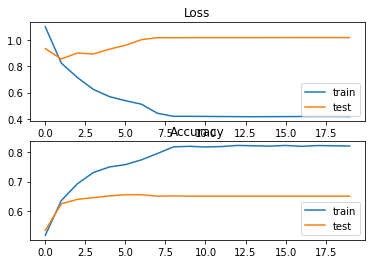

In [55]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [50]:
# attention-based lstm with aspect embedding
def atae_lstm(lstm_units = 128):
    input_text = Input(shape=(Max_Len,))
    input_aspect = Input(shape=(1,),)
    
    word_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    text_embed = SpatialDropout1D(0.2)(word_embedding(input_text))

    asp_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)

    aspect_embed = asp_embedding(input_aspect)
    aspect_embed = Flatten()(aspect_embed)  # reshape to 2d
    repeat_aspect = RepeatVector(Max_Len)(aspect_embed)  # repeat aspect for every word in sequence

    input_concat = concatenate([text_embed, repeat_aspect], axis=-1)
    print(input_concat.shape)
    hidden_vecs, state_h, _ = LSTM(lstm_units, return_sequences=True, return_state=True)(input_concat)
    concat = concatenate([hidden_vecs, repeat_aspect], axis=-1)

    # apply attention mechanism
    attend_weight = Attention()(concat)
    attend_weight_expand = Lambda(lambda x: K.expand_dims(x))(attend_weight)
    attend_hidden = multiply([hidden_vecs, attend_weight_expand])
    attend_hidden = Lambda(lambda x: K.sum(x, axis=1))(attend_hidden)

    attend_hidden_dense = Dense(lstm_units)(attend_hidden)
    last_hidden_dense = Dense(lstm_units)(state_h)
    final_output = Activation('tanh')(add([attend_hidden_dense, last_hidden_dense]))

    return Model([input_text, input_aspect], final_output)

In [51]:
atae_lstm_model =  atae_lstm()
atae_lstm_model.summary()

(None, 77, 256)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 77)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 128)       12800000    input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 77, 128)      12800000    input_3[0][0]                    
____________________________________________________________________________

## Model Training

In [52]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience = 1,
                                                    verbose=1,
                                                    factor=0.1,
                                                    min_lr=0.000001)
atae_lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
atae_lstm_model .fit(x = train_data, y = y_train,validation_data = (test_data, y_test), batch_size=32, epochs=50, callbacks = [learning_rate_reduction])

Epoch 1/50
58/58 [==============================] - 17s 235ms/step - loss: 1.3993 - accuracy: 0.4508 - val_loss: 0.9841 - val_accuracy: 0.5551
Epoch 2/50
58/58 [==============================] - 13s 217ms/step - loss: 0.8787 - accuracy: 0.5984 - val_loss: 1.0744 - val_accuracy: 0.5767
Epoch 3/50
58/58 [==============================] - 13s 217ms/step - loss: 0.6595 - accuracy: 0.7314 - val_loss: 1.4418 - val_accuracy: 0.6458
Epoch 4/50
58/58 [==============================] - 12s 215ms/step - loss: 0.5135 - accuracy: 0.8465 - val_loss: 2.0819 - val_accuracy: 0.6112

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/50
58/58 [==============================] - 12s 212ms/step - loss: 0.3412 - accuracy: 0.8984 - val_loss: 2.5416 - val_accuracy: 0.6436

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/50
58/58 [==============================] - 12s 214ms/step - loss: 0.2985 - accuracy: 0.9124 - val_loss: 2.5868 -

In [ ]:
atae_lstm_model

## Model Evaluation

In [53]:
print("Evaluate on test data")
results = atae_lstm_model.evaluate(x = test_data , y = y_test )
print("test loss, test acc:", results)
print("Accuracy of the model is - " , results[1]*100 , "%")

Evaluate on test data
15/15 [==============================] - 0s 6ms/step - loss: 2.6952 - accuracy: 0.6458
test loss, test acc: [2.6952474117279053, 0.645788311958313]
Accuracy of the model is -  64.5788311958313 %


In [91]:
y_test

2412    2
1887    2
2965    0
3718    0
2594    0
       ..
3618    1
3791    2
1469    2
975     2
3866    2
Name: polarity, Length: 463, dtype: int64

In [90]:
test_data

[array([[   0,    0,    0, ...,  565,  191,  595],
        [   0,    0,    0, ...,  141, 1757,  662],
        [   0,    0,    0, ...,   70,  326,   62],
        ...,
        [   0,    0,    0, ...,  931,  191,  128],
        [   0,    0,    0, ..., 1423,  596,   66],
        [   0,    0,    0, ..., 1781,  226,   82]], dtype=int32),
 array([[ 595],
        [ 662],
        [  62],
        [2889],
        [   0],
        [1230],
        [  33],
        [ 264],
        [ 354],
        [2144],
        [  45],
        [  92],
        [ 356],
        [ 173],
        [ 373],
        [ 279],
        [  97],
        [  35],
        [ 626],
        [ 106],
        [  53],
        [ 179],
        [ 512],
        [1421],
        [ 176],
        [  62],
        [  91],
        [ 156],
        [   0],
        [ 185],
        [  56],
        [ 144],
        [ 356],
        [ 761],
        [  53],
        [ 359],
        [ 142],
        [ 595],
        [  99],
        [ 449],
        [ 118],
        [ 

In [35]:
sentances = ["The battery is good. But the processor is bit slow than what i expected.","The battery is good. But the processor is bit slow than what i expected."]
aspects = ['battery', 'performance']

In [36]:
sentance_tokenized = tokenizer.texts_to_sequences(sentances) # list of tokenized sentences
Aspect_X_train_tokenized = tokenizer.texts_to_sequences(aspects) # list of tokenized sentences

text_X_train_padded = pad_sequences(sentance_tokenized, maxlen=Max_Len)
aspect_X_train_padded = pad_sequences(Aspect_X_train_tokenized, maxlen=1)


In [37]:
sample = [text_X_train_padded, aspect_X_train_padded]

In [40]:
ae_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       12800000    input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 77)]         0                                            
__________________________________________________________________________________________________
tf.reshape (TFOpLambda)         (None, 1, 128)       0           embedding_1[0][0]                
______________________________________________________________________________________________